In [74]:
import pandas as pd
import yfinance as yf
import numpy as np
import glob
import os
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import plotly.express as px
import simpful as sf
from simpful import *
import matplotlib.pyplot as plt

In [75]:
at_eur_1h = pd.read_csv('data/indicators_eurusd_1h.csv')

In [76]:
at_eur_1h

,id,name,Open,Close,High,Low,data_volume,data_datetime,timeframe,Name,...,15MA,12Ewm,26Ewm,MACD,low_14,high_14,k_percent,B_MA,BU,BL
0,41482,EURUSD,1.06074,1.06056,1.06083,1.05995,0.0,2023-03-16 06:00:00.000,1h,EURUSD,...,1.062542,1.064645,1.065467,-0.000822,1.05425,1.07463,30.961727,1.064059,1.075502,1.052616
1,41512,EURUSD,1.06297,1.06262,1.06334,1.06122,0.0,2023-03-17 12:00:00.000,1h,EURUSD,...,1.062684,1.064334,1.065256,-0.000922,1.05425,1.07463,41.069676,1.063649,1.074653,1.052646
2,41537,EURUSD,1.07050,1.07238,1.07308,1.07030,0.0,2023-03-20 13:00:00.000,1h,EURUSD,...,1.063378,1.065572,1.065784,-0.000212,1.05425,1.07463,88.959764,1.063734,1.074986,1.052481
3,41562,EURUSD,1.07777,1.07741,1.07798,1.07608,0.0,2023-03-21 14:00:00.000,1h,EURUSD,...,1.064849,1.067393,1.066645,0.000748,1.05425,1.07798,97.597977,1.064398,1.077209,1.051587
4,41592,EURUSD,1.08650,1.08551,1.08655,1.08546,0.0,2023-03-22 20:00:00.000,1h,EURUSD,...,1.066653,1.070180,1.068042,0.002138,1.05425,1.08655,96.780186,1.065230,1.081066,1.049393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5294,67712,EURUSD,1.06960,1.07016,1.07051,1.06901,0.0,2023-11-13 18:00:00.000,1h,EURUSD,...,1.068834,1.069131,1.069200,-0.000069,1.06651,1.07058,89.680590,1.069726,1.078503,1.060949
5295,67702,EURUSD,1.06991,1.06957,1.07061,1.06936,0.0,2023-11-13 17:00:00.000,1h,EURUSD,...,1.068855,1.069198,1.069227,-0.000029,1.06651,1.07061,74.634146,1.069785,1.078540,1.061030
5296,67682,EURUSD,1.06730,1.06769,1.06801,1.06679,0.0,2023-11-13 14:00:00.000,1h,EURUSD,...,1.068812,1.068966,1.069114,-0.000147,1.06651,1.07061,28.780488,1.069747,1.078533,1.060960
5297,67698,EURUSD,1.06888,1.06992,1.07038,1.06852,0.0,2023-11-13 16:00:00.000,1h,EURUSD,...,1.068902,1.069113,1.069173,-0.000060,1.06651,1.07061,83.170732,1.069823,1.078586,1.061060


## Generate signals MA

In [77]:
def generate_signals(df):
    # Check if short-term moving average is greater than long-term moving average
    df['Signal'] = 0.0  
    
    # Replace 0.0 with 1.0 where short_mavg > long_movg
    df.loc[df['5MA'] > df['15MA'], 'Signal'] = 1.0

In [78]:
generate_signals(at_eur_1h)

In [79]:
at_eur_1h['Signal'].value_counts()

Signal
1.0    2655
0.0    2644
Name: count, dtype: int64

## Fuzzy Moving Average Crossover Strategy

### NMA

In [80]:
def calculate_NMA(df):
    fast_ma = df['5MA']
    slow_ma = df['15MA']
    
    nma = 100 * ((fast_ma - slow_ma)/fast_ma)
    
    return nma

In [81]:
at_eur_1h['NMA'] = calculate_NMA(at_eur_1h)


## Fuzzification NMA

In [83]:
def create_fuzzy_system(data, variable_name, signal_variable):
    FS = FuzzySystem()
    
    terms = ['low', 'medium', 'high']
    
    uof_L = data[variable_name].min().astype(float)
    uof_U = data[variable_name].max().astype(float)
    universe_of_discourse = [uof_L, uof_U]
        
    # Statistics for triangular fuzzy sets
    stats = data.describe().loc[['25%', '50%', '75%']]

    fuzzy_sets = AutoTriangle(3, terms=['low', 'medium', 'high'], universe_of_discourse=universe_of_discourse)

    # Adding a linguistic variable to a fuzzy system
    FS.add_linguistic_variable(variable_name, fuzzy_sets)

    # Create labels for the results (SELL, HOLD, BUY) with variable values of triangular fuzzy sets
    signal_sets = []
    for i, term in enumerate(terms):
        low_stat = stats.loc['25%', f"{variable_name}"]
        high_stat = stats.loc['75%', f"{variable_name}"]
        medium_stat = stats.loc['50%', f"{variable_name}"]

        # Adaptation of the triangular fuzzy set to the range of quantiles
        if i == 0:
            O = TriangleFuzzySet(universe_of_discourse[0], low_stat, medium_stat, term='BUY')
        elif i == len(terms) - 1:
            O = TriangleFuzzySet(medium_stat, high_stat, universe_of_discourse[1], term='HOLD')
        else:
            O = TriangleFuzzySet(low_stat, medium_stat, high_stat, term='SELL')

        signal_sets.append(O)

    # Adding the linguistic variable 'Signal' to the fuzzy system
    FS.add_linguistic_variable(signal_variable, LinguisticVariable(signal_sets, universe_of_discourse=universe_of_discourse))

    # Define fuzzy rules
    FS.add_rules([
        f"IF ({variable_name} IS low) THEN ({signal_variable} IS SELL)",
        f"IF ({variable_name} IS medium) THEN ({signal_variable} IS HOLD)",
        f"IF ({variable_name} IS high) THEN ({signal_variable} IS BUY)"
    ])

    return FS


In [84]:
FS_NMA = create_fuzzy_system(at_eur_1h, "NMA", 'Signal')

# Set the value of the NMA variable according to statistics
FS_NMA.set_variable("NMA", at_eur_1h["NMA"].mean())


result_ma = FS_NMA.inference()

print(f"Inference result: {result_ma}")

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Inference result: {'Signal': 0.4144947560001072}


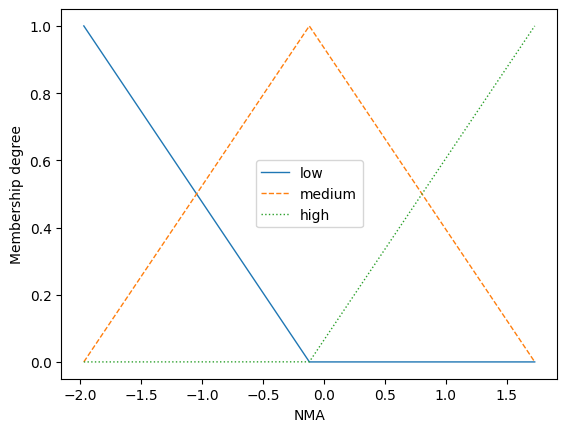

In [85]:
FS_NMA.plot_variable("NMA")

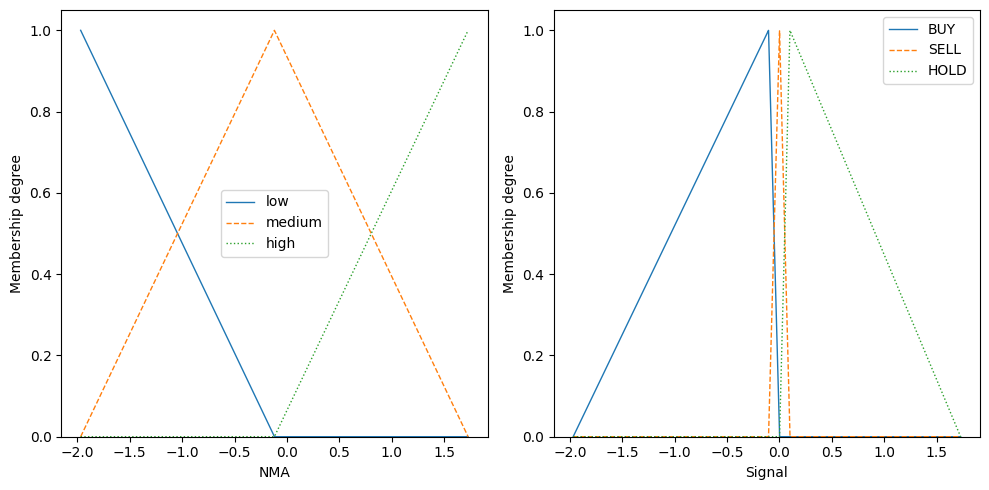

In [86]:
FS_NMA.produce_figure("NMA")

## Fuzzy MACD strategy

### fuzzMACDInput

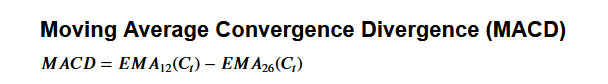

In [87]:
def fuzzyMACDInput(df):
    '''
    Przecięcie powyżej lini sygnałowej - kup
    Przecięcie poniżej lini sygnałowej - sprzedaj
    '''
    MACD = df['MACD']
    df['9Ewm'] = df.groupby('Name')['Close'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

    SignalLine = df['9Ewm'] 
    fuzzMACD = 100 * ((MACD - SignalLine) / MACD)
   # fuzzMACD = (MACD - SignalLine) / MACD.std()
        
    return fuzzMACD

In [88]:
at_eur_1h['fuzzMACD'] = fuzzyMACDInput(at_eur_1h)

In [89]:
def create_signal_macd(df):
    df['Signal_MACD'] = 'HOLD'
    df.loc[df['MACD'] - df['9Ewm'] > 0, 'Signal_MACD'] = 'BUY'
    df.loc[df['MACD'] - df['9Ewm'] < 0, 'Signal_MACD'] = 'SELL'
    return df['Signal_MACD']


In [90]:
create_signal_macd(at_eur_1h)

0       SELL
1       SELL
2       SELL
3       SELL
4       SELL
        ... 
5294    SELL
5295    SELL
5296    SELL
5297    SELL
5298    SELL
Name: Signal_MACD, Length: 5299, dtype: object

In [91]:
at_eur_1h['Signal_MACD'].value_counts()

Signal_MACD
SELL    5299
Name: count, dtype: int64

In [92]:
at_eur_1h[['MACD', '9Ewm', 'Signal_MACD']]

,MACD,9Ewm,Signal_MACD
0,-0.000822,1.060560,SELL
1,-0.000922,1.060972,SELL
2,-0.000212,1.063254,SELL
3,0.000748,1.066085,SELL
4,0.002138,1.069970,SELL
...,...,...,...
5294,-0.000069,1.069109,SELL
5295,-0.000029,1.069201,SELL
5296,-0.000147,1.068899,SELL
5297,-0.000060,1.069103,SELL


In [93]:
FS_MACD = create_fuzzy_system(at_eur_1h, "fuzzMACD", 'Signal_MACD')

# Set the value of the NMA variable according to statistics
FS_MACD.set_variable("fuzzMACD", at_eur_1h["fuzzMACD"].mean())


result_macd = FS_MACD.inference()

print(f"Inference result: {result_macd}")

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Inference result: {'Signal_MACD': 1538676602.3712265}


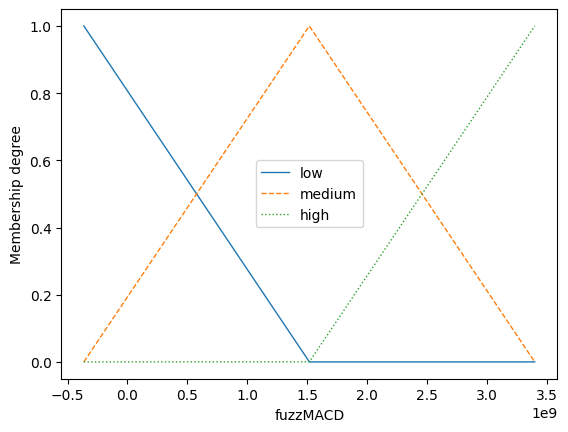

In [94]:
FS_MACD.plot_variable("fuzzMACD")

## Fuzzy Bollinger Bands strategy

In [95]:
def fuzzyInputUpperBand(df):
    close = df['Close']
    upperBand = df['BU']
    fuzzUBollinger = 100 * ((close - upperBand)/close)
    return fuzzUBollinger
    
def fuzzyInputLowerBand(df):
    close = df['Close']
    lowerBand = df['BL']
    fuzzLBollinger = 100 * ((close - lowerBand)/close)
    return fuzzLBollinger

In [96]:
at_eur_1h['fuzz_U_Bollinger'] = fuzzyInputUpperBand(at_eur_1h)


at_eur_1h['fuzz_L_Bollinger'] = fuzzyInputLowerBand(at_eur_1h)
at_eur_1h.head()

,id,name,Open,Close,High,Low,data_volume,data_datetime,timeframe,Name,...,B_MA,BU,BL,Signal,NMA,9Ewm,fuzzMACD,Signal_MACD,fuzz_U_Bollinger,fuzz_L_Bollinger
0,41482,EURUSD,1.06074,1.06056,1.06083,1.05995,0.0,2023-03-16 06:00:00.000,1h,EURUSD,...,1.064059,1.075502,1.052616,1.0,0.365141,1.060560,129180.267095,SELL,-1.408850,0.749010
1,41512,EURUSD,1.06297,1.06262,1.06334,1.06122,0.0,2023-03-17 12:00:00.000,1h,EURUSD,...,1.063649,1.074653,1.052646,1.0,0.435852,1.060972,115132.185942,SELL,-1.132361,0.938594
2,41537,EURUSD,1.07050,1.07238,1.07308,1.07030,0.0,2023-03-20 13:00:00.000,1h,EURUSD,...,1.063734,1.074986,1.052481,1.0,0.426245,1.063254,501317.326951,SELL,-0.243024,1.855606
3,41562,EURUSD,1.07777,1.07741,1.07798,1.07608,0.0,2023-03-21 14:00:00.000,1h,EURUSD,...,1.064398,1.077209,1.051587,1.0,0.421624,1.066085,-142433.290791,SELL,0.018700,2.396722
4,41592,EURUSD,1.08650,1.08551,1.08655,1.08546,0.0,2023-03-22 20:00:00.000,1h,EURUSD,...,1.065230,1.081066,1.049393,1.0,0.470594,1.069970,-49950.238401,SELL,0.409365,3.327220


In [97]:
def create_signal_bb(df):
    df['Signal_BB'] = 'HOLD'

    # Conditions for fuzzyInputUpperBand
    df.loc[df['fuzz_U_Bollinger'] == 'High', 'Signal_BB'] = 'BUY'
    df.loc[df['fuzz_U_Bollinger'] == 'Normal', 'Signal_BB'] = 'HOLD'
    df.loc[df['fuzz_U_Bollinger'] == 'Low', 'Signal_BB'] = 'HOLD'

    # Conditions for fuzzyInputlowerBand
    df.loc[df['fuzz_L_Bollinger'] == 'High', 'Signal_BB'] = 'SELL'
    df.loc[df['fuzz_L_Bollinger'] == 'Normal', 'Signal_BB'] = 'HOLD'
    df.loc[df['fuzz_L_Bollinger'] == 'Low', 'Signal_BB'] = 'HOLD'

    return df['Signal_BB']

In [98]:
create_signal_bb(at_eur_1h)

0       HOLD
1       HOLD
2       HOLD
3       HOLD
4       HOLD
        ... 
5294    HOLD
5295    HOLD
5296    HOLD
5297    HOLD
5298    HOLD
Name: Signal_BB, Length: 5299, dtype: object

In [99]:
at_eur_1h['Signal_BB'].value_counts()

Signal_BB
HOLD    5299
Name: count, dtype: int64

In [100]:
def create_fuzzy_system_bollinger(data, upper_band_variable, lower_band_variable, signal_variable):
    FS = FuzzySystem()

    terms = ['low', 'medium', 'high']

    uof_U = data[upper_band_variable].max().astype(float)
    uof_L = data[lower_band_variable].min().astype(float)
    universe_of_discourse = [uof_L, uof_U]

    # Statistics for triangular fuzzy sets
    stats_upper = data.describe().loc[['25%', '50%', '75%'], upper_band_variable]
    stats_lower = data.describe().loc[['25%', '50%', '75%'], lower_band_variable]

    fuzzy_sets_upper = AutoTriangle(3, terms=terms, universe_of_discourse=universe_of_discourse)
    fuzzy_sets_lower = AutoTriangle(3, terms=terms, universe_of_discourse=universe_of_discourse)

    # Adding linguistic variables to the fuzzy system
    FS.add_linguistic_variable(upper_band_variable, fuzzy_sets_upper)
    FS.add_linguistic_variable(lower_band_variable, fuzzy_sets_lower)

    # Create labels for the results (SELL, HOLD, BUY) with variable values of triangular fuzzy sets
    signal_sets = []
    for i, term in enumerate(terms):
        low_stat_upper = stats_upper.loc['25%']
        high_stat_upper = stats_upper.loc['75%']
        medium_stat_upper = stats_upper.loc['50%']

        low_stat_lower = stats_lower.loc['25%']
        high_stat_lower = stats_lower.loc['75%']
        medium_stat_lower = stats_lower.loc['50%']

        # Adaptation of the triangular fuzzy set to the range of quantiles
        if term == 'low':
            O = TriangleFuzzySet(universe_of_discourse[0], low_stat_upper, medium_stat_upper, term='SELL')
        elif term == 'medium':
            O = TriangleFuzzySet(low_stat_upper, medium_stat_upper, high_stat_upper, term='HOLD')
        else:
            O = TriangleFuzzySet(medium_stat_upper, high_stat_upper, universe_of_discourse[1], term='BUY')

        signal_sets.append(O)

    # Adding the linguistic variable 'Signal' to the fuzzy system
    FS.add_linguistic_variable(signal_variable, LinguisticVariable(signal_sets, universe_of_discourse=universe_of_discourse))

    # Define fuzzy rules
    FS.add_rules([
        f"IF ({upper_band_variable} IS low) AND ({lower_band_variable} IS low) THEN ({signal_variable} IS SELL)",
        f"IF ({upper_band_variable} IS medium) AND ({lower_band_variable} IS medium) THEN ({signal_variable} IS HOLD)",
        f"IF ({upper_band_variable} IS high) AND ({lower_band_variable} IS high) THEN ({signal_variable} IS BUY)",
    ])

    return FS


In [101]:
# Create the Bollinger Bands fuzzy system
bollinger_FS = create_fuzzy_system_bollinger(at_eur_1h, 'fuzz_U_Bollinger', 'fuzz_L_Bollinger', 'Signal_Bollinger')

# Use the set_variable method to set the input values
bollinger_FS.set_variable('fuzz_U_Bollinger', data_point['fuzz_U_Bollinger'])
bollinger_FS.set_variable('fuzz_L_Bollinger', data_point['fuzz_L_Bollinger'])

# Perform fuzzy inference
result_bb = bollinger_FS.inference()

print(f"Inference result: {result}")

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Inference result: {'Signal_Bollinger': -0.4963519246754551}


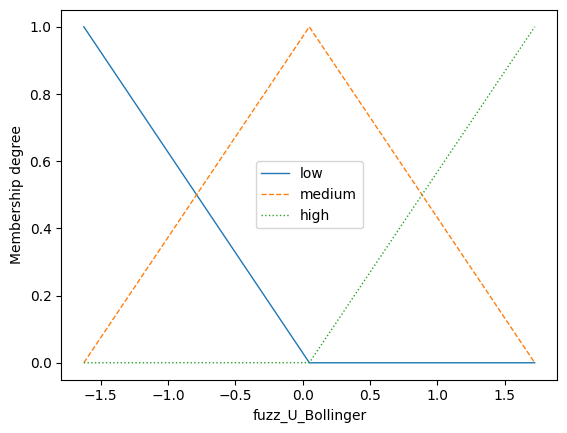

In [103]:
bollinger_FS.plot_variable("fuzz_U_Bollinger")

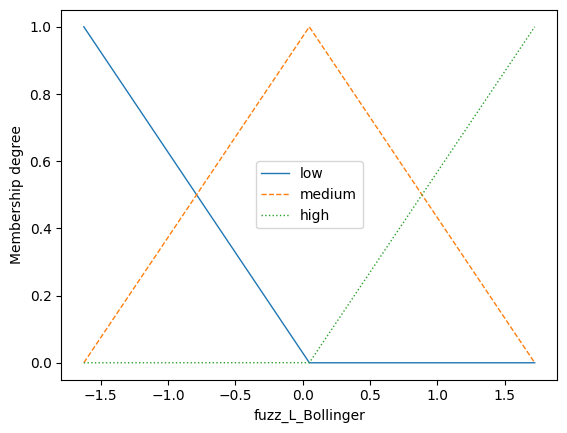

In [104]:
bollinger_FS.plot_variable("fuzz_L_Bollinger")

### =====================
[Simpful on github](https://github.com/aresio/simpful/blob/master/simpful/simpful.py)
### =====================

## Fuzzy RSI strategy

In [105]:
def fuzzRSIone(df):
    RSI = df['RSI']
    fuzzRSIone = 100 * (RSI - 70)/RSI
    return fuzzRSIone
    
def fuzzRSItwo(df):
    RSI = df['RSI']
    fuzzRSItwo = 100 * (RSI - 30)/RSI
    return fuzzRSItwo


In [106]:
at_eur_1h['fuzzRSIone'] = fuzzRSIone(at_eur_1h)

at_eur_1h['fuzzRSItwo'] = fuzzRSItwo(at_eur_1h)

at_eur_1h.head()

,id,name,Open,Close,High,Low,data_volume,data_datetime,timeframe,Name,...,Signal,NMA,9Ewm,fuzzMACD,Signal_MACD,fuzz_U_Bollinger,fuzz_L_Bollinger,Signal_BB,fuzzRSIone,fuzzRSItwo
0,41482,EURUSD,1.06074,1.06056,1.06083,1.05995,0.0,2023-03-16 06:00:00.000,1h,EURUSD,...,1.0,0.365141,1.060560,129180.267095,SELL,-1.408850,0.749010,HOLD,-39.867711,40.056695
1,41512,EURUSD,1.06297,1.06262,1.06334,1.06122,0.0,2023-03-17 12:00:00.000,1h,EURUSD,...,1.0,0.435852,1.060972,115132.185942,SELL,-1.132361,0.938594,HOLD,-38.792525,40.517489
2,41537,EURUSD,1.07050,1.07238,1.07308,1.07030,0.0,2023-03-20 13:00:00.000,1h,EURUSD,...,1.0,0.426245,1.063254,501317.326951,SELL,-0.243024,1.855606,HOLD,-14.868965,50.770443
3,41562,EURUSD,1.07777,1.07741,1.07798,1.07608,0.0,2023-03-21 14:00:00.000,1h,EURUSD,...,1.0,0.421624,1.066085,-142433.290791,SELL,0.018700,2.396722,HOLD,-13.196395,51.487259
4,41592,EURUSD,1.08650,1.08551,1.08655,1.08546,0.0,2023-03-22 20:00:00.000,1h,EURUSD,...,1.0,0.470594,1.069970,-49950.238401,SELL,0.409365,3.327220,HOLD,-8.720474,53.405511


In [107]:
def create_signal_rsi(df):
    df['Signal_RSI'] = 'HOLD'

    # Conditions for fuzzyRSIOne
    df.loc[df['fuzzRSIone'] == 'High', 'Signal_RSI'] = 'BUY'
    df.loc[df['fuzzRSIone'] == 'Normal', 'Signal_RSI'] = 'HOLD'
    df.loc[df['fuzzRSIone'] == 'Low', 'Signal_RSI'] = 'HOLD'

    # Conditions for fuzzyRSITwo
    df.loc[df['fuzzRSItwo'] == 'High', 'Signal_RSI'] = 'SELL'
    df.loc[df['fuzzRSItwo'] == 'Normal', 'Signal_RSI'] = 'HOLD'
    df.loc[df['fuzzRSItwo'] == 'Low', 'Signal_RSI'] = 'HOLD'

    return df['Signal_RSI']

In [108]:
create_signal_rsi(at_eur_1h)


0       HOLD
1       HOLD
2       HOLD
3       HOLD
4       HOLD
        ... 
5294    HOLD
5295    HOLD
5296    HOLD
5297    HOLD
5298    HOLD
Name: Signal_RSI, Length: 5299, dtype: object

In [109]:
at_eur_1h['Signal_RSI'].value_counts()

Signal_RSI
HOLD    5299
Name: count, dtype: int64

In [115]:
# Using function for Bollinger Bands
rsi_FS = create_fuzzy_system_bollinger(at_eur_1h, 'fuzzRSIone', 'fuzzRSItwo', 'Signal_RSI')

# Use the set_variable method to set the input values
rsi_FS.set_variable('fuzzRSIone', data_point['fuzz_U_Bollinger']) # create_fuzzy_system_bollinger()
rsi_FS.set_variable('fuzzRSItwo', data_point['fuzz_L_Bollinger']) # create_fuzzy_system_bollinger()

# Perform fuzzy inference
result_rsi = rsi_FS.inference()

print(f"Inference result: {result_rsi}")

  ____  __  _  _  ____  ____  _  _  __   
 / ___)(  )( \/ )(  _ \(  __)/ )( \(  ) v2.11.1 
 \___ \ )( / \/ \ ) __/ ) _) ) \/ (/ (_/\ 
 (____/(__)\_)(_/(__)  (__)  \____/\____/

 Created by Marco S. Nobile (m.s.nobile@tue.nl)
 and Simone Spolaor (simone.spolaor@unimib.it)

Inference result: {'Signal_RSI': -12.24622075908724}


In [114]:
print(data_point.keys())

dict_keys(['fuzz_U_Bollinger', 'fuzz_L_Bollinger'])


## Fuzzy Stochastic Oscilator

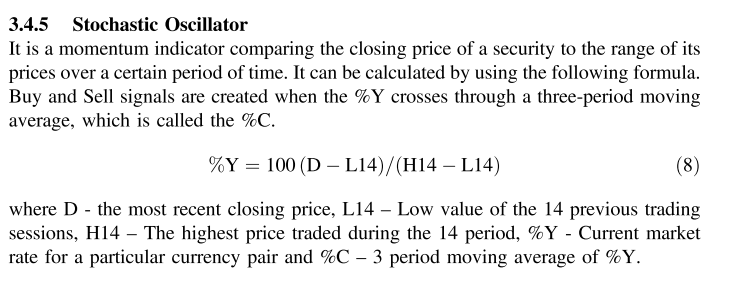

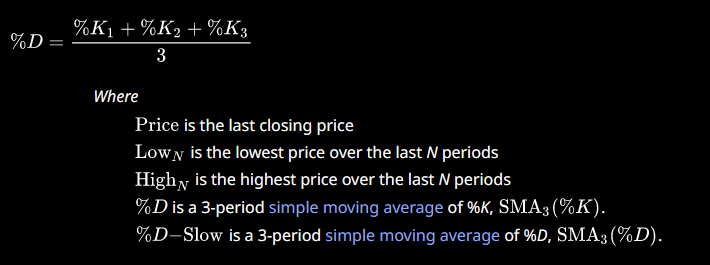

In [2]:
def fuzzStochastic(df):
    '''
    fuzzyStochastic = %Y - %C
    
    Stochastic oscilator %K - 'k_percent'
     %Y = %K
     %C = %D
    '''
    y = df['k_percent']
    c = df['']
    fuzzStochastic = y - c
    return fuzzStochastic

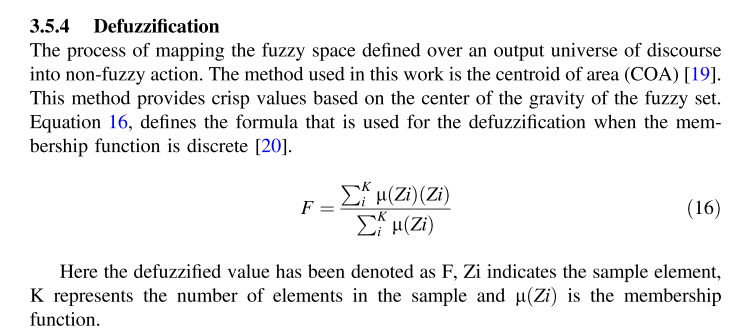